In [85]:
from statistics import mean
from tkinter import Y
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import iqr

In [86]:
data = pd.read_csv("Granite1.csv")
data = data.iloc[2:102]
data.index = np.arange(0, len(data))

X = data[[" X", " Y", " Hardness(GPa)", " Modulus"]]
tempdf = X.copy()
tempdf

,X,Y,Hardness(GPa),Modulus
0,-3.770873,0.002520,0.387642,6.648113
1,-2.771181,0.002699,1.224675,32.848149
2,-1.771469,0.002709,156.045745,1888.860122
3,-0.771161,0.002709,1.841265,37.080645
4,0.228789,0.002699,10.465644,178.110457
...,...,...,...,...
95,1.228045,-8.997162,25.739224,211.007222
96,2.227500,-8.997162,42.664982,681.374523
97,3.227748,-8.997162,63.865255,362.929557
98,4.227718,-8.997162,26.693745,185.871818


Extracting Outliers

In [87]:
"""iqr_multiplier_hard = 1.5 * iqr(X[" Hardness(GPa)"])
third_quar_hard = np.percentile(X[" Hardness(GPa)"], 75)
first_quar_hard = np.percentile(X[" Hardness(GPa)"], 25)
iqr_multiplier_mod = 1.5 * iqr(X[" Modulus"])
third_quar_mod = np.percentile(X[" Modulus"], 75)
first_quar_mod = np.percentile(X[" Modulus"], 25)

outliers = pd.DataFrame(columns=["X","Y","Hardness","Modulus","Index"])

for x in range(len(X[" Hardness(GPa)"])):
    if tempdf[" Hardness(GPa)"][x] > (iqr_multiplier_hard + third_quar_hard) or tempdf[" Hardness(GPa)"][x] < (first_quar_hard - iqr_multiplier_hard):
        outliers.loc[len(outliers.index)] = [float(X[" X"][x]), float(X[" Y"][x]), float(X[" Hardness(GPa)"][x]), float(X[" Modulus"][x]),x]
        tempdf.drop(index=x, inplace=True,axis=0)
    else:
        if tempdf[" Modulus"][x] > (iqr_multiplier_mod + third_quar_mod) or tempdf[" Modulus"][x] < (first_quar_mod - iqr_multiplier_mod):
            tempdf.drop(index=x,inplace=True)
            outliers.loc[len(outliers.index)] = [X[" X"][x], X[" Y"][x], X[" Hardness(GPa)"][x], X[" Modulus"][x], x]

tempdf"""

'iqr_multiplier_hard = 1.5 * iqr(X[" Hardness(GPa)"])\nthird_quar_hard = np.percentile(X[" Hardness(GPa)"], 75)\nfirst_quar_hard = np.percentile(X[" Hardness(GPa)"], 25)\niqr_multiplier_mod = 1.5 * iqr(X[" Modulus"])\nthird_quar_mod = np.percentile(X[" Modulus"], 75)\nfirst_quar_mod = np.percentile(X[" Modulus"], 25)\n\noutliers = pd.DataFrame(columns=["X","Y","Hardness","Modulus","Index"])\n\nfor x in range(len(X[" Hardness(GPa)"])):\n    if tempdf[" Hardness(GPa)"][x] > (iqr_multiplier_hard + third_quar_hard) or tempdf[" Hardness(GPa)"][x] < (first_quar_hard - iqr_multiplier_hard):\n        outliers.loc[len(outliers.index)] = [float(X[" X"][x]), float(X[" Y"][x]), float(X[" Hardness(GPa)"][x]), float(X[" Modulus"][x]),x]\n        tempdf.drop(index=x, inplace=True,axis=0)\n    else:\n        if tempdf[" Modulus"][x] > (iqr_multiplier_mod + third_quar_mod) or tempdf[" Modulus"][x] < (first_quar_mod - iqr_multiplier_mod):\n            tempdf.drop(index=x,inplace=True)\n            outli

In [88]:
iqr_multiplier_hard = 1.5 * iqr(X[" Hardness(GPa)"])
third_quar_hard = np.percentile(X[" Hardness(GPa)"], 75)
first_quar_hard = np.percentile(X[" Hardness(GPa)"], 25)
iqr_multiplier_mod = 1.5 * iqr(X[" Modulus"])
third_quar_mod = np.percentile(X[" Modulus"], 75)
first_quar_mod = np.percentile(X[" Modulus"], 25)

for x in range(len(X[" Hardness(GPa)"])):
    if tempdf[" Hardness(GPa)"][x] > (iqr_multiplier_hard + third_quar_hard) or tempdf[" Hardness(GPa)"][x] < (first_quar_hard - iqr_multiplier_hard):
        tempdf[" Hardness(GPa)"][x] = None
    if tempdf[" Modulus"][x] > (iqr_multiplier_mod + third_quar_mod) or tempdf[" Modulus"][x] < (first_quar_mod - iqr_multiplier_mod):
        if tempdf[" Modulus"][x] > (iqr_multiplier_mod + third_quar_mod) or tempdf[" Modulus"][x] < (first_quar_mod - iqr_multiplier_mod):
            tempdf[" Modulus"][x] = None

tempdf

,X,Y,Hardness(GPa),Modulus
0,-3.770873,0.002520,0.387642,6.648113
1,-2.771181,0.002699,1.224675,32.848149
2,-1.771469,0.002709,NaN,NaN
3,-0.771161,0.002709,1.841265,37.080645
4,0.228789,0.002699,10.465644,178.110457
...,...,...,...,...
95,1.228045,-8.997162,25.739224,211.007222
96,2.227500,-8.997162,42.664982,NaN
97,3.227748,-8.997162,NaN,362.929557
98,4.227718,-8.997162,26.693745,185.871818


In [89]:
tempdf = tempdf.interpolate()
tempdf

,X,Y,Hardness(GPa),Modulus
0,-3.770873,0.002520,0.387642,6.648113
1,-2.771181,0.002699,1.224675,32.848149
2,-1.771469,0.002709,1.532970,34.964397
3,-0.771161,0.002709,1.841265,37.080645
4,0.228789,0.002699,10.465644,178.110457
...,...,...,...,...
95,1.228045,-8.997162,25.739224,211.007222
96,2.227500,-8.997162,42.664982,286.968390
97,3.227748,-8.997162,34.679363,362.929557
98,4.227718,-8.997162,26.693745,185.871818


Interpolate Outliers

In [90]:
"""for i in range(len(outliers)):
    hard_new = outliers["Hardness"][i]
    mod_new = outliers["Modulus"][i]
    if outliers["Hardness"][i] > (iqr_multiplier_hard + third_quar_hard) or outliers["Hardness"][i] < (first_quar_hard - iqr_multiplier_hard):
        o_l = tempdf.loc[round(tempdf[" Y"], 2) == round(outliers["Y"][i], 2)]
        hard_interp = interpolate.interp1d(o_l[" X"], o_l[" Hardness(GPa)"], kind="linear", fill_value="extrapolate")
        hard_new = hard_interp(outliers["X"][i])
    if outliers["Modulus"][i] > (iqr_multiplier_mod + third_quar_mod) or outliers["Modulus"][i] < (first_quar_mod - iqr_multiplier_mod):
        o_l = tempdf.loc[round(tempdf[" Y"], 2) == round(outliers["Y"][i], 2)]
        mod_interp = interpolate.interp1d(o_l[" X"], o_l[" Modulus"], kind="linear", fill_value="extrapolate")
        mod_new = mod_interp(outliers["X"][i])
    tempdf.loc[outliers["Index"][i]] = [outliers["X"][i], outliers["Y"][i], hard_new, mod_new]

tempdf"""

'for i in range(len(outliers)):\n    hard_new = outliers["Hardness"][i]\n    mod_new = outliers["Modulus"][i]\n    if outliers["Hardness"][i] > (iqr_multiplier_hard + third_quar_hard) or outliers["Hardness"][i] < (first_quar_hard - iqr_multiplier_hard):\n        o_l = tempdf.loc[round(tempdf[" Y"], 2) == round(outliers["Y"][i], 2)]\n        hard_interp = interpolate.interp1d(o_l[" X"], o_l[" Hardness(GPa)"], kind="linear", fill_value="extrapolate")\n        hard_new = hard_interp(outliers["X"][i])\n    if outliers["Modulus"][i] > (iqr_multiplier_mod + third_quar_mod) or outliers["Modulus"][i] < (first_quar_mod - iqr_multiplier_mod):\n        o_l = tempdf.loc[round(tempdf[" Y"], 2) == round(outliers["Y"][i], 2)]\n        mod_interp = interpolate.interp1d(o_l[" X"], o_l[" Modulus"], kind="linear", fill_value="extrapolate")\n        mod_new = mod_interp(outliers["X"][i])\n    tempdf.loc[outliers["Index"][i]] = [outliers["X"][i], outliers["Y"][i], hard_new, mod_new]\n\ntempdf'

Data Normalization

In [91]:
max_hard = max(tempdf[" Hardness(GPa)"])
min_hard = min(tempdf[" Hardness(GPa)"])
max_mod =  max(tempdf[" Modulus"])
min_mod = min(tempdf[" Modulus"])
max_x = max(tempdf[" X"])
min_x = min(tempdf[" X"])
max_y = max(tempdf[" Y"])
min_y = min(tempdf[" Y"])

for x in range(len(tempdf)):
    tempdf[" Hardness(GPa)"][x] = (tempdf[" Hardness(GPa)"][x]-min_hard)/(max_hard-min_hard)
    tempdf[" Modulus"][x] = (tempdf[" Modulus"][x]-min_mod)/(max_mod-min_mod)
    tempdf[" Y"][x] = round((tempdf[" Y"][x]-min_y)/(max_y-min_y), 2)
    tempdf[" X"][x] = round((tempdf[" X"][x]-min_x)/(max_x-min_x), 2)

tempdf

,X,Y,Hardness(GPa),Modulus
0,0.00,1.0,0.000517,0.000000
1,0.11,1.0,0.017389,0.073537
2,0.22,1.0,0.023602,0.079477
3,0.33,1.0,0.029816,0.085417
4,0.44,1.0,0.203648,0.481255
...,...,...,...,...
95,0.56,0.0,0.511500,0.573589
96,0.67,0.0,0.852654,0.786794
97,0.78,0.0,0.691697,1.000000
98,0.89,0.0,0.530740,0.503040


Add Data Points

In [92]:
tempdf = tempdf.sort_index()
tempdf

x = np.linspace(0, 1, 10)
y = np.linspace(1, 0, 10)
xx,yy = np.meshgrid(x,y)
z_h = tempdf[" Hardness(GPa)"].to_numpy().reshape([10,10])
z_m = tempdf[" Modulus"].to_numpy().reshape([10,10])

hard_interp_norm=interpolate.interp2d(x, y, z_h, kind="linear")
mod_interp_norm=interpolate.interp2d(x, y, z_m, kind="linear")

In [93]:
new_temp = pd.DataFrame()
pts = 100
feature_x = np.linspace(0, 1, pts)
feature_y = np.linspace(1, 0, pts)

new_temp["X"] = list(feature_x) * pts
arr = []
for i in list(feature_y):
    arr.append([i]*pts)
new_temp["Y"] = np.array(arr).reshape([pts*pts, 1])

feature_hard = hard_interp_norm(feature_x, feature_y).reshape([pts*pts,1])
feature_mod = mod_interp_norm(feature_x, feature_y).reshape([pts*pts,1])
feature_hard = [i[0] for i in feature_hard]
feature_mod = [i[0] for i in feature_mod]

#weights of x and y
new_temp["X"] = 1 * new_temp["X"]
new_temp["Y"] = 1 * new_temp["Y"]
new_temp["Hardness"] = feature_hard
new_temp["Modulus"] = feature_mod

new_temp
#new_temp.to_csv("G1.csv")

,X,Y,Hardness,Modulus
0,0.000000,1.0,0.101479,0.372610
1,0.010101,1.0,0.114797,0.365287
2,0.020202,1.0,0.128114,0.357964
3,0.030303,1.0,0.141431,0.350641
4,0.040404,1.0,0.154748,0.343318
...,...,...,...,...
9995,0.959596,0.0,0.175726,0.295034
9996,0.969697,0.0,0.161277,0.292003
9997,0.979798,0.0,0.146829,0.288973
9998,0.989899,0.0,0.132381,0.285942


K-Means Clustering

In [94]:
km = KMeans(n_clusters = 4, init = "k-means++", max_iter=300,n_init=10,random_state=0)
km.fit(new_temp)
clusters = km.predict(new_temp)
new_temp["Cluster"]=clusters

color=["red", "blue", "green", "black"]

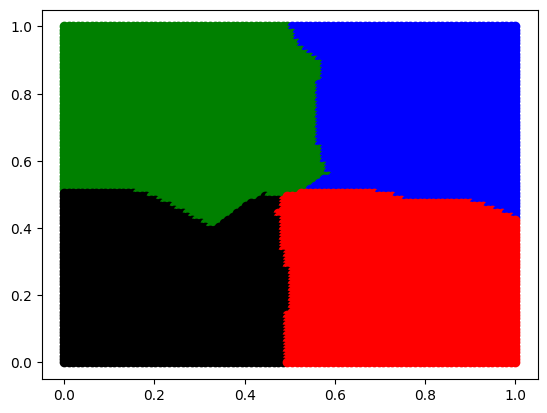

In [95]:
for i in range(len(new_temp)):
    plt.scatter(new_temp["X"][i], new_temp["Y"][i], c = color[new_temp["Cluster"][i]])

Contour Map

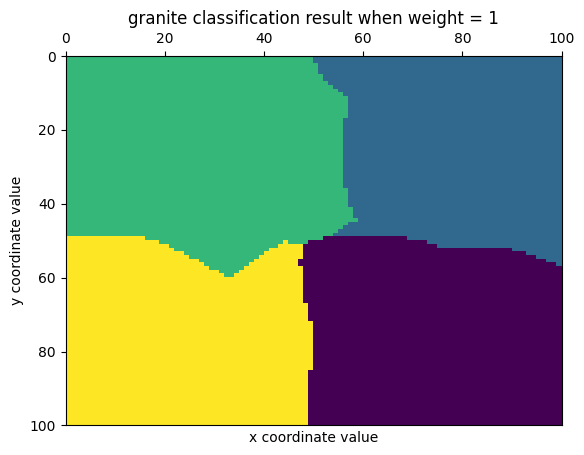

In [96]:
from matplotlib.colors import LinearSegmentedColormap

z_cluster = new_temp["Cluster"].to_numpy().reshape([pts,pts])

fig,ax = plt.subplots()
plt.pcolor(z_cluster)
plt.ylim(100,0)
plt.title("granite classification result when weight = 1")
plt.xlabel("x coordinate value")
plt.ylabel("y coordinate value")
ax.xaxis.tick_top()

In [97]:
"""cluster_1 = new_temp[new_temp["Cluster"]==0]
cluster_2 = new_temp[new_temp["Cluster"]==1]
cluster_3 = new_temp[new_temp["Cluster"]==2]
cluster_4 = new_temp[new_temp["Cluster"]==3]

print(cluster_1)
print(cluster_2)
print(cluster_3)
print(cluster_4)

print("Cluster 1 Hardness + Modulus")
print("Variance")
print(cluster_1["Hardness"].var())
print(cluster_1["Modulus"].var())
print("Mean")
print(cluster_1["Hardness"].mean())
print(cluster_1["Modulus"].mean())
print("\nCluster 2 Hardness + Modulus")
print("Variance")
print(cluster_2["Hardness"].var())
print(cluster_2["Modulus"].var())
print("Mean")
print(cluster_2["Hardness"].mean())
print(cluster_2["Modulus"].mean())
print("\nCluster 3 Hardness + Modulus")
print("Variance")
print(cluster_3["Hardness"].var())
print(cluster_3["Modulus"].var())
print("Mean")
print(cluster_3["Hardness"].mean())
print(cluster_3["Modulus"].mean())
print("\nCluster 4 Hardness + Modulus")
print("Variance")
print(cluster_4["Hardness"].var())
print(cluster_4["Modulus"].var())
print("Mean")
print(cluster_4["Hardness"].mean())
print(cluster_4["Modulus"].mean())"""

'cluster_1 = new_temp[new_temp["Cluster"]==0]\ncluster_2 = new_temp[new_temp["Cluster"]==1]\ncluster_3 = new_temp[new_temp["Cluster"]==2]\ncluster_4 = new_temp[new_temp["Cluster"]==3]\n\nprint(cluster_1)\nprint(cluster_2)\nprint(cluster_3)\nprint(cluster_4)\n\nprint("Cluster 1 Hardness + Modulus")\nprint("Variance")\nprint(cluster_1["Hardness"].var())\nprint(cluster_1["Modulus"].var())\nprint("Mean")\nprint(cluster_1["Hardness"].mean())\nprint(cluster_1["Modulus"].mean())\nprint("\nCluster 2 Hardness + Modulus")\nprint("Variance")\nprint(cluster_2["Hardness"].var())\nprint(cluster_2["Modulus"].var())\nprint("Mean")\nprint(cluster_2["Hardness"].mean())\nprint(cluster_2["Modulus"].mean())\nprint("\nCluster 3 Hardness + Modulus")\nprint("Variance")\nprint(cluster_3["Hardness"].var())\nprint(cluster_3["Modulus"].var())\nprint("Mean")\nprint(cluster_3["Hardness"].mean())\nprint(cluster_3["Modulus"].mean())\nprint("\nCluster 4 Hardness + Modulus")\nprint("Variance")\nprint(cluster_4["Hardnes